In [45]:
# Install or upgrade the 'datasets' library
!pip install -U datasets

In [46]:
import polars as pl
import pandas
from datasets import Dataset

# Load the dataset from a parquet file hosted on the Hugging Face Hub using polars
df = pl.read_parquet('hf://datasets/Intuit-GenSRF/hate-speech18-es/data/train-00000-of-00001-3075deaca2ec2f5b.parquet')

# Convert the polars DataFrame to a pandas DataFrame
df = df.to_pandas()

# Convert the pandas DataFrame to a Hugging Face Dataset object
hate = Dataset.from_pandas(df)

In [47]:
# Print the column names of the dataset
print(hate.column_names)

# Print the total number of examples in the dataset
print(len(hate))

# Print the first example in the dataset
print(hate[0])

['text', 'user_id', 'subforum_id', 'num_contexts', 'labels', 'processed_text', 'text_es']
10944
{'text': 'As of March 13th , 2014 , the booklet had been downloaded over 18,300 times and counting .', 'user_id': 572066, 'subforum_id': 1346, 'num_contexts': 0, 'labels': [], 'processed_text': ['As of March 13th , 2014 , the booklet had been downloaded over 18,300 times and counting .'], 'text_es': 'Al 13 de marzo de 2014 , el folleto había sido descargado más de 18.300 veces y contando .'}


In [48]:
import random
from datasets import concatenate_datasets

# Shuffle the original dataset and select the first 500 examples to create a smaller subset
small_hate = hate.shuffle(seed=42).select(range(500))

# Define a function to convert the 'labels' column (list of strings) to a binary label (0 or 1)
# If the 'labels' list is not empty, the label is 1 (hate speech), otherwise it's 0 (not hate speech)
def to_binary(example):
    return {"text": example["text"], "label": 1 if example["labels"] else 0}

# Apply the to_binary function to the small_hate dataset to create a new dataset with binary labels
# Remove the original columns except 'text' and the new 'label' column
binary_hate = small_hate.map(to_binary, remove_columns=[c for c in small_hate.column_names if c not in ("text","label")])

# Get the indices of examples with label 1 (hate speech)
idx_pos = [i for i, ex in enumerate(binary_hate) if ex["label"] == 1]

# Get the indices of examples with label 0 (not hate speech)
idx_neg = [i for i, ex in enumerate(binary_hate) if ex["label"] == 0]

# Define a function to sample indices from a list, with replacement if the list is smaller than the desired sample size
def sample_indices(idxs, n):
    if len(idxs) >= n:
        return random.sample(idxs, n)
    else:
        return [random.choice(idxs) for _ in range(n)]

# Sample 500 indices from the positive examples (with replacement if less than 100 positive examples)
sampled_pos = sample_indices(idx_pos, 100)

# Sample 500 indices from the negative examples (with replacement if less than 100 negative examples)
sampled_neg = sample_indices(idx_neg, 100)

# Select the examples corresponding to the sampled indices for both positive and negative classes
ds_pos = binary_hate.select(sampled_pos)
ds_neg = binary_hate.select(sampled_neg)

# Concatenate the positive and negative datasets and shuffle them to create a balanced dataset
balanced = concatenate_datasets([ds_pos, ds_neg]).shuffle(seed=42)

# Import Counter from collections to count the occurrences of each label
from collections import Counter

# Print the distribution of labels in the balanced dataset
print(Counter(balanced["label"]))

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Counter({0: 100, 1: 100})


Label distribution in the balanced dataset: Counter({0: 100, 1: 100})


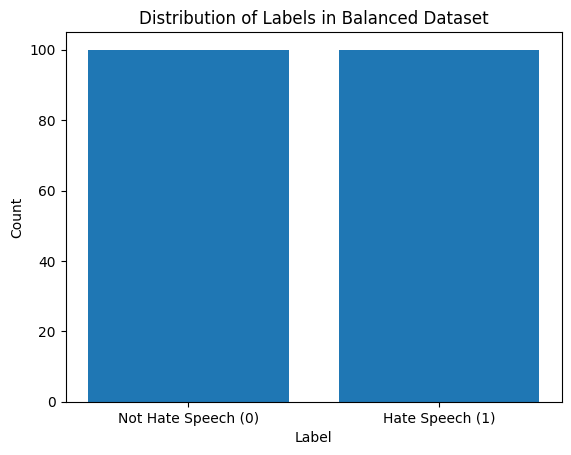

In [49]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each label in the balanced dataset
label_counts = Counter(balanced["label"])

# Print the label distribution
print("Label distribution in the balanced dataset:", label_counts)

# Create a bar plot to visualize the label distribution
plt.bar(label_counts.keys(), label_counts.values())

# Set the x-axis tick labels to be more descriptive
plt.xticks([0, 1], ['Not Hate Speech (0)', 'Hate Speech (1)'])

# Set the x-axis label
plt.xlabel("Label")

# Set the y-axis label
plt.ylabel("Count")

# Set the title of the plot
plt.title("Distribution of Labels in Balanced Dataset")

# Display the plot
plt.show()

In [50]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# Load the tokenizer for the 'bert-base-uncased' model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define a function to tokenize a batch of text examples
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],       # Input text to tokenize
        padding="max_length", # Pad sequences to the maximum length
        truncation=True,      # Truncate sequences longer than max_length
        max_length=128        # Set the maximum sequence length
    )

# Apply the tokenization function to the balanced dataset
tokenized = balanced.map(tokenize_batch, batched=True)

# Set the format of the dataset to PyTorch tensors for specific columns
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Create a DataLoader for the tokenized dataset for training
# Batch size is 16, and data is shuffled
train_loader = DataLoader(tokenized, batch_size=16, shuffle=True)

# Get the first batch from the DataLoader
batch = next(iter(train_loader))

# Print the shapes of the tensors in the batch
print({k: v.shape for k, v in batch.items()})

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'label': torch.Size([16]), 'input_ids': torch.Size([16, 128]), 'attention_mask': torch.Size([16, 128])}


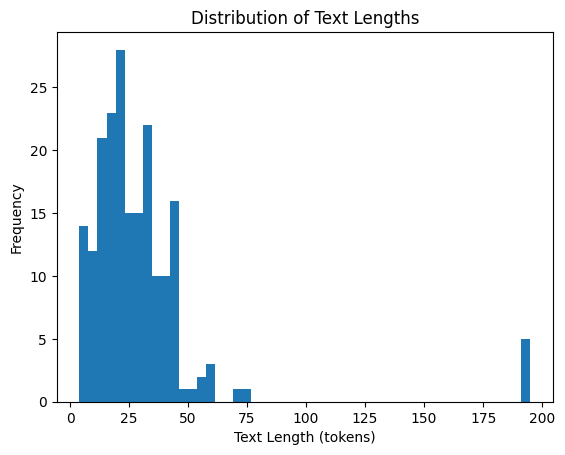

In [51]:
import matplotlib.pyplot as plt

# Calculate the length of each text example in tokens using the tokenizer
text_lengths = [len(tokenizer.encode(example["text"])) for example in balanced]

# Create a histogram to visualize the distribution of text lengths
plt.hist(text_lengths, bins=50)

# Set the x-axis label
plt.xlabel("Text Length (tokens)")

# Set the y-axis label
plt.ylabel("Frequency")

# Set the title of the plot
plt.title("Distribution of Text Lengths")

# Display the plot
plt.show()

In [52]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import pandas as pd

# Download the stopwords corpus from NLTK
nltk.download('stopwords')

# Get the set of English stop words
stop_words = set(stopwords.words('english'))

# Define a function to get the most common words for a given label in the dataset
def get_most_common_words(dataset, label, num_words=20):
    # Join all text examples for the given label into a single string
    text_for_label = " ".join([example["text"] for example in dataset if example["label"] == label])

    # Convert the text to lowercase and split it into words
    words = text_for_label.lower().split()

    # Filter out non-alphabetic words and stop words
    words = [word for word in words if word.isalpha() and word not in stop_words]

    # Count the frequency of each word
    word_counts = Counter(words)

    # Return the most common words and their counts
    return word_counts.most_common(num_words)

# Get the most common words for the 'Not Hate Speech' label (0)
common_words_neg = get_most_common_words(balanced, 0)

# Get the most common words for the 'Hate Speech' label (1)
common_words_pos = get_most_common_words(balanced, 1)

# Print the most common words for the 'Not Hate Speech' label
print("Most common words in 'Not Hate Speech' (Label 0):")
for word, count in common_words_neg:
    print(f"{word}: {count}")

# Print the most common words for the 'Hate Speech' label
print("\nMost common words in 'Hate Speech' (Label 1):")
for word, count in common_words_pos:
    print(f"{word}: {count}")

Most common words in 'Not Hate Speech' (Label 0):
like: 11
white: 11
see: 8
go: 7
last: 6
people: 6
school: 6
well: 5
think: 5
give: 4
shows: 4
youtube: 4
would: 4
kids: 4
get: 4
coming: 4
always: 4
pick: 3
much: 3
show: 3

Most common words in 'Hate Speech' (Label 1):
sweden: 43
https: 35
ghlight: 35
madex: 21
breed: 17
like: 16
make: 15
black: 12
blacks: 9
plymouth: 9
people: 9
put: 8
prison: 8
yes: 7
muslims: 7
vermin: 7
believe: 7
part: 7
intention: 7
races: 7


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


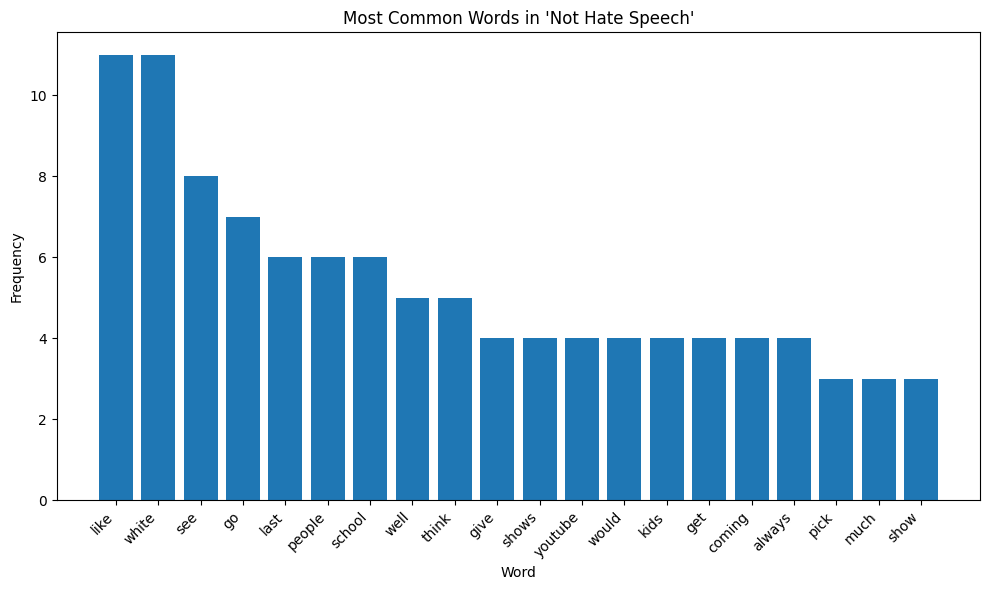

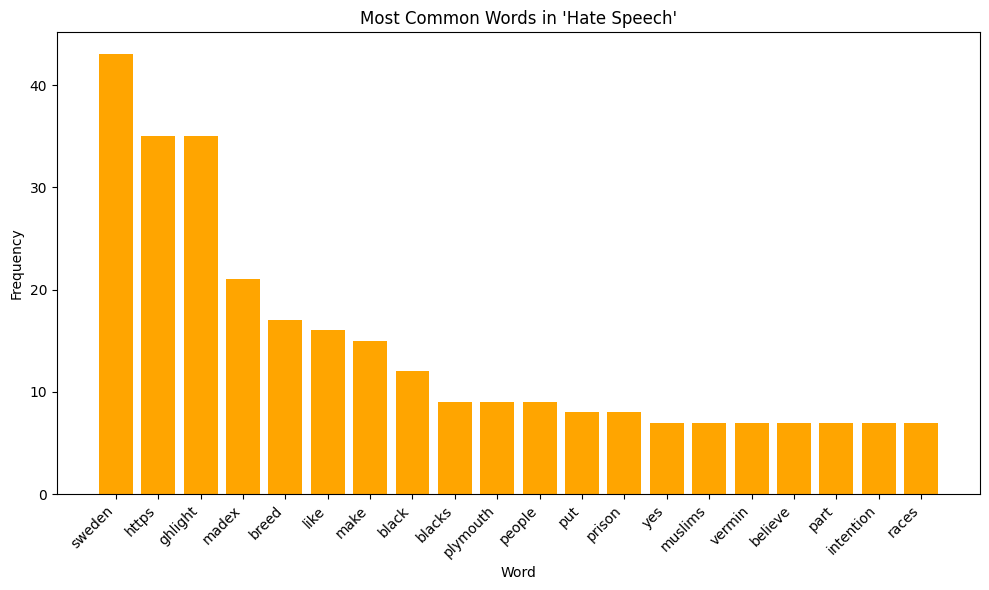

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a pandas DataFrame from the common words and counts for the negative class
df_neg = pd.DataFrame(common_words_neg, columns=['word', 'count'])

# Create a pandas DataFrame from the common words and counts for the positive class
df_pos = pd.DataFrame(common_words_pos, columns=['word', 'count'])

# Create a figure and axes for the first plot (Not Hate Speech)
plt.figure(figsize=(10, 6))

# Create a bar plot of the most common words for the negative class
plt.bar(df_neg['word'], df_neg['count'])

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the x-axis label
plt.xlabel("Word")

# Set the y-axis label
plt.ylabel("Frequency")

# Set the title of the plot
plt.title("Most Common Words in 'Not Hate Speech'")

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()

# Create a figure and axes for the second plot (Hate Speech)
plt.figure(figsize=(10, 6))

# Create a bar plot of the most common words for the positive class with orange color
plt.bar(df_pos['word'], df_pos['count'], color='orange')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the x-axis label
plt.xlabel("Word")

# Set the y-axis label
plt.ylabel("Frequency")

# Set the title of the plot
plt.title("Most Common Words in 'Hate Speech'")

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [54]:
from transformers import (
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Load the pre-trained BERT model for sequence classification
# Specify the number of labels (2 for binary classification)
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

# Define a function to compute evaluation metrics
def compute_metrics(eval_pred):
    # Get logits and true labels from the evaluation predictions
    logits, labels = eval_pred

    # Get the predicted class by finding the index of the maximum logit
    preds = np.argmax(logits, axis=-1)

    # Calculate and return accuracy, F1 score, precision, and recall
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="binary"), # Use binary average for binary classification
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
    }

# Define the training arguments for the Trainer
training_args = TrainingArguments(
    output_dir="./results",              # Directory to save the model checkpoints and outputs
    num_train_epochs=3,                 # Total number of training epochs
    per_device_train_batch_size=16,      # Batch size per device during training
    per_device_eval_batch_size=32,       # Batch size per device during evaluation
    warmup_steps=50,                     # Number of steps for the warmup phase of the learning rate scheduler
    weight_decay=0.01,                   # Strength of weight decay
    logging_steps=10,                    # Log training information every 10 steps
    eval_strategy="steps",               # Evaluate the model every `logging_steps`
    eval_steps=50,                       # Evaluate the model every `evaluation steps`
    load_best_model_at_end=True,         # Load the best model checkpoint at the end of training
    metric_for_best_model="f1",          # Metric to use to determine the best model
    report_to="none",                    # Do not report training progress to any external service
)

# Initialize the Trainer with the model, training arguments, datasets, and compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized, # Use the tokenized dataset for training
    eval_dataset=tokenized,  # Use the tokenized dataset for evaluation (can be a separate validation set)
    compute_metrics=compute_metrics,
)

# Start the training process
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=39, training_loss=0.5730665891598432, metrics={'train_runtime': 30.1338, 'train_samples_per_second': 19.911, 'train_steps_per_second': 1.294, 'total_flos': 39466658304000.0, 'train_loss': 0.5730665891598432, 'epoch': 3.0})

In [55]:
# Evaluate the trained model on the evaluation dataset
trainer.evaluate()

{'eval_loss': 0.21756450831890106,
 'eval_accuracy': 0.985,
 'eval_f1': 0.9849246231155779,
 'eval_precision': 0.98989898989899,
 'eval_recall': 0.98,
 'eval_runtime': 1.5054,
 'eval_samples_per_second': 132.856,
 'eval_steps_per_second': 4.65,
 'epoch': 3.0}

In [56]:
import numpy as np

# Make predictions on the tokenized dataset using the trained model
predictions = trainer.predict(tokenized)

# Extract the true labels from the predictions object
true_labels = predictions.label_ids

# Get the predicted labels by finding the index of the maximum logit for each prediction
predicted_labels = np.argmax(predictions.predictions, axis=-1)

In [57]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix using the true and predicted labels
cm = confusion_matrix(true_labels, predicted_labels)

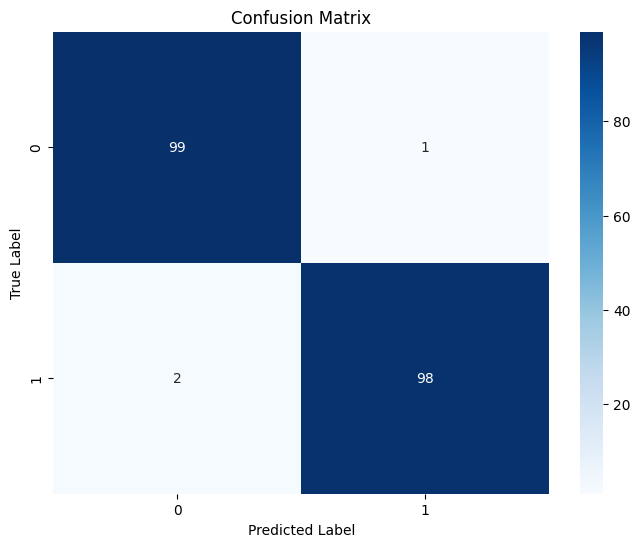

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure for the heatmap
plt.figure(figsize=(8, 6))

# Create a heatmap of the confusion matrix
# annot=True displays the values in the cells
# fmt="d" formats the annotations as integers
# cmap="Blues" sets the color map to blues
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Set the x-axis label
plt.xlabel("Predicted Label")

# Set the y-axis label
plt.ylabel("True Label")

# Set the title of the plot
plt.title("Confusion Matrix")

# Display the plot
plt.show()

In [59]:
import torch

# Shuffle the original dataset and select the text from the first 3 examples
sample_texts = hate.shuffle(seed=42).select(range(3))['text']

# Define a dictionary to map class indices to human-readable labels
label_map = {0: "Not Hate Speech", 1: "Hate Speech"}

# Determine the device to use for inference (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

# Iterate through the sample texts
for sample_text in sample_texts:
    # Tokenize the sample text and convert it to PyTorch tensors
    # Add padding and truncation to match the model's input requirements
    inputs = tokenizer(sample_text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)

    # Move the input tensors to the selected device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform inference without calculating gradients
    with torch.no_grad():
        # Pass the inputs through the model to get the outputs (logits)
        outputs = model(**inputs)

    # Get the predicted class by finding the index with the highest logit
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Get the human-readable label for the predicted class
    predicted_label = label_map[predicted_class]

    # Print the sample text, predicted class, and predicted label
    print(f"Sample Text: '{sample_text}'")
    print(f"Predicted Class: {predicted_class}")
    print(f"Predicted Label: {predicted_label}\n")

Sample Text: 'Also after sticking them on you can coat them in a flour/water mixture like they use for large posters and it dries see through and is damn near impossible to remove later .'
Predicted Class: 0
Predicted Label: Not Hate Speech

Sample Text: 'She 'll smell of it for a while then it 'll be gone in a matter of seconds .'
Predicted Class: 0
Predicted Label: Not Hate Speech

Sample Text: 'I miss Dr. Pierce very much !'
Predicted Class: 0
Predicted Label: Not Hate Speech

